# EI2001: Ciencia de Datos en Astronomía
**Profesores:** Pía Cortés, Daniela Barrientos, Matías Suazo, Matías Mattamala

# Actividad Clase 5 - Clasificación con Machine Learning
## Separando estrellas de galaxias con los datos de SDSS

**Objetivos:** 
1. Introducción al Machine Learning en Python
2. Librería Scikit Learn
3. Uso de Métodos de clasificacion
4. Preaparacion de datos
5. Creacion de Modelo
6. Clasificación
 
 

Antes de comenzar la actividad, instalaremos el paquete de descarga de bases de datos astronómicas  [`astroquery`](https://astroquery.readthedocs.io/en/latest/). 

Ejecuta la siguiente celda, que realizará la instalación del paquete en tu entorno de ejecución temporal. 

In [1]:
# Al agregar ! convertimos nuestro codigo de python a bash (lenguaje usado en la terminal)
!pip install --pre  --quiet astroquery

    100% |████████████████████████████████| 4.2MB 5.3MB/s 
    100% |████████████████████████████████| 61kB 21.0MB/s 
    100% |████████████████████████████████| 2.3MB 12.6MB/s 
    100% |████████████████████████████████| 102kB 27.2MB/s 


# Motivación 
## ¿Por qué usar algoritmos de Aprendizaje de Máquinas?


Muchas de las aplicaciones de la ciencia hecha a partir de surveys astronómicos, dependen de la clasificación inicial de los objetos observados. Por ejemplo, pongámonos en el caso de querer estudiar la estructura de la Vía Láctea a partir de observaciones como las de SDSS o futuramente LSST. Estas imágenes contienen tanto estrellas locales como galaxias en sus imágenes, por lo que el paso cero de nuestra investigación sería separar las estrellas de las galaxias en nuestros catálogos. 

Ahora, ¿por qué es necesario usar Machine Learning para esto? 

Generalmente obtener una clasificación es caro. En el contexto de nuestro problema de estrellas versus galaxias, la clasificación real es confirmada mediante espectroscopía. Pero, obtener espectros requiere de tiempos de exposición mayores y no se realiza para todas las fuentes. En SDSS existen $\gt 10^{8}$ fuentes, de las cuales solo $\sim 10^{6}$ tienen espectros.

![Espectros](https://raw.githubusercontent.com/astrodatos/Clase5/master/imagenes/espectros.png)

Por otro lado, podemos hacernos una idea de la clasificación entre estrella y galaxia mirando las imágenes, las estrellas son objetos puntuales, mientras que las galaxias son extendidas. Pero esto necesitaría de una inspección visual para cada fuente en el catálogo, lo que nuevamente, es muy caro.

![Imágen Estrella](https://raw.githubusercontent.com/astrodatos/Clase5/master/imagenes/estrella.png =300x300)      ![Imágen Galaxia](https://github.com/astrodatos/Clase5/raw/master/imagenes/gal.png =300x300)

Aquí es donde el Machine Learning puede ayudarnos. A través del uso de algoritmos de ML podemos encontrar una separación de los objetos en nuestros catálogos en el espacio de múltiples de sus atributos. Muchas veces esta separación sucede en un espacio de varias dimensiones, que seríamos incapaces de detectar de otro modo.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

%matplotlib inline
#%matplotlib notebook


#Cambiar formato de graficos

plt.rcParams.update({'axes.labelsize' : 18})
plt.rcParams.update({'axes.titlesize' : 20})
plt.rcParams.update({'legend.fontsize' : 15})

El siguiente es un ejemplo de cómo aumentar las dimensiones a veces revela separaciones en nuestros datos. 

In [0]:
# Definimos las posiciones para 3 nubes de puntos

b1_x = np.random.normal(2, 0.5, 100) 
b2_x = np.random.normal(1, 0.5, 100)
b3_x = np.random.normal(5, 0.5, 100)

b1_y = np.random.normal(1, 0.5, 100) 
b2_y = np.random.normal(1, 0.5, 100)
b3_y = np.random.normal(5, 0.5, 100)

b1_z = np.random.normal(1, 0.5, 100) 
b2_z = np.random.normal(5, 0.5, 100)
b3_z = np.random.normal(5, 0.5, 100)

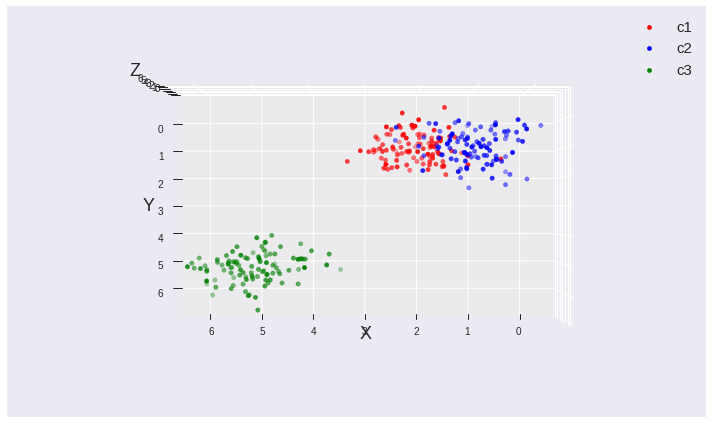

In [4]:
fig = plt.figure(figsize = (10,6))
ax = plt.axes(projection='3d')
ax.scatter3D(b1_x,b1_y,b1_z, color = 'r', label = 'c1')
ax.scatter3D(b2_x,b2_y,b2_z, color = 'b', label = 'c2')
ax.scatter3D(b3_x,b3_y,b3_z, color = 'g', label = 'c3')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(90, 90)
ax.legend()
plt.tight_layout()

# Preparación de Datos

## Sloan Digital Sky Survey ([SDSS](https://www.sdss.org/))


Los datos que utilizaremos para crear nuestro modelo de clasificación provendran del Sloan Digital Sky Survey, un proyecto astronómico que mapeó distintas zonas del cielo realizando tanto imágenes como espectros para una cantidad enorme de fuentes. 

Esto nos da la ventaja de obtener tanto los atributos, en este caso la fotometría, como las clases, que fueron obtenidas mediante espectros, a partir del mismo set de datos.

La gente de SDSS además de obtener los espectros e imágenes 'crudas' en multiples bandas, procesó estos datos para obtener la fotometría y una serie de parámetros por fuente. (Puedes mirar la lista de parámetros y sus definiciones [aqui](http://skyserver.sdss.org/dr15/en/help/browser/browser.aspx#&&history=description+PhotoObjAll+U)).

No podemos usar las 454  propiedades calculadas por objeto, es por esto que el primer paso en la construcción de nuestro clasificador será elegir los atributos a utilizar en esta clasificación.  

Para este ejemplo básico nos limitaremos a utilizar solo la fotometría en la banda r, obtenida mediante diferentes modelamientos.
 
 


### Cargar Datos desde SDSS

El paquete de python `astroquery` nos provee de una herramienta para acceder a las bases de datos de múltiples surveys astronómicos. En este caso utilizaremos sus módulos para extraer datos de SDSS. 

El formato para realizar la petición es la siguiente:

* __SELECT__: columnas que se quiere obtener.
  * Fotometría en la banda r, para distintos modelos fotométricos.
    * Atributos: `psfMag_r`, `fiberMag_r`, `fiber2Mag_r`, `petroMag_r`, `devMag_r`, `expMag_r`,
  `modelMag_r`, `cModelMag_r`
    * Clases: `class`  
  

* __FROM__: tabla desde donde obtener datos.
  * Fotometría desde `PhotoObjAll` y clases de `specObjAll`.

* __WHERE__: condiciones para elegir las fuentes.
  * Se eligen objetos con buena fotometría y que solo sean de las clases Star y Galaxy.


In [0]:
from astroquery.sdss import SDSS

In [6]:
# Vamos a seleccionar 20000 objetos de los catálogos de SDSS

data = SDSS.query_sql("""SELECT TOP 20000
                      p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
                      p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
                      s.class
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO'
                      
                      """)

/usr/local/lib/python3.6/dist-packages/astroquery/sdss/core.py:865: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


In [0]:
# Cambiamos el formato de la tabla obtenida con astroquery a pandas.

data_df = data.to_pandas()

In [8]:
# Miremos los primeros 10 objetos

data_df[:10]

,psfMag_r,fiberMag_r,fiber2Mag_r,petroMag_r,deVMag_r,expMag_r,modelMag_r,cModelMag_r,class
0,20.84498,20.94056,21.52410,20.21043,20.17926,20.40387,20.17926,20.17926,b'GALAXY'
1,21.35784,21.51477,22.04900,21.26664,21.06857,21.10284,21.10284,21.10284,b'GALAXY'
2,21.70617,21.85586,22.41572,20.82812,20.89326,21.21087,20.89328,20.89326,b'GALAXY'
3,17.79862,17.79761,18.43037,16.43511,16.35287,16.74637,16.35286,16.35287,b'GALAXY'
4,21.50151,21.28290,21.93224,20.29523,20.27570,20.72075,20.27570,20.27570,b'GALAXY'
5,21.12719,21.25681,21.83808,19.96804,20.14513,20.49478,20.14507,20.14513,b'STAR'
6,20.97313,21.04968,21.64774,20.15119,20.10240,20.33214,20.10243,20.11384,b'GALAXY'
7,20.60808,20.90819,21.38455,20.70182,20.61366,20.61337,20.61366,20.61366,b'STAR'
8,17.76642,17.67537,18.34037,16.22469,16.07633,16.45666,16.07633,16.11027,b'GALAXY'
9,21.75565,21.74575,22.35892,21.01648,20.73366,20.99669,20.99669,20.95294,b'GALAXY'


Como podemos ver, nuestra tabla contiene 8 columnas de atributos y una columna con las clases: 'STAR' y 'GALAXY'.

In [0]:
# Primero identificamos las clases existentes 

clases = data_df['class'].unique()

mapa = {}

for clase, i in enumerate(clases):
    mapa[i] = clase

In [10]:
# Creamos un mapeo entre las clases originales (strings) y las nuevas (enteros)
mapa

{b'GALAXY': 0, b'STAR': 1}

In [0]:
# Separamos entre atributos y clases (cambiando el formato de las clases)

X = np.array(data_df.iloc[:,:-1])          # Arreglo con atributos


y = np.array(data_df['class'].map(mapa))   # Arreglo con clases 0 y 1

Una cosa importante de considerar al hacer la separación de nuestros datos en sets de entrenamiento y prueba, es la distribución de las clases en ellos. La separación debe ser realizada de tal forma que todas las clases esten representadas en ambos conjuntos. 

In [0]:
# Usamos una funcion de scikit learn para dividir nuestro conjunto al azar

from sklearn.model_selection import train_test_split

rs = 1851   #Guardamos la semilla 
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = rs)

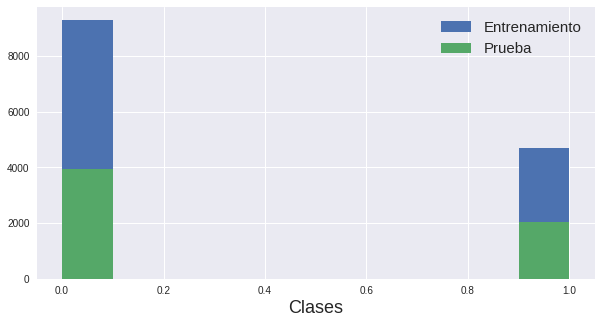

In [13]:
# Veamos las distribuciones de clases para cada set

plt.figure(figsize = (10,5))

plt.hist(train_y, label = 'Entrenamiento')
plt.hist(test_y, label = 'Prueba')
plt.xlabel('Clases')
plt.legend()

#### Inincializar un modelo

In [0]:
# Utilizaremos la implementación de scikit-learn de esta matriz

from sklearn.metrics import confusion_matrix

In [0]:
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matriz de confusion normalizada'
        else:
            title = 'Matriz de confusion, sin normalizacion'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusion normalizada")
    else:
        print('Matriz de confusion, sin normalizacion')

    print(cm)

    fig, ax = plt.subplots(figsize = (8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta Real',
           xlabel='Etiqueta Predicha')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=15)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), fontsize=25,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            
    ax.grid(False)
    fig.tight_layout()
    return ax

#KNN

In [29]:
# Vamos a utilizar la implementacion del algoritmo knn de scikitlearn

from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=25)   # Debemos especificar el numero
                                                 #de vecinos, en este caso escogemos 25
knn_clf.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

In [0]:
# Hacemos la clasificacion del set de prueba

pred_test = knn_clf.predict(test_X)

In [31]:
pred_test

array([1, 0, 0, ..., 0, 0, 0])

In [32]:
test_y

array([1, 0, 0, ..., 0, 0, 0])

Matriz de confusion normalizada
[[0.97271349 0.02728651]
 [0.02938296 0.97061704]]


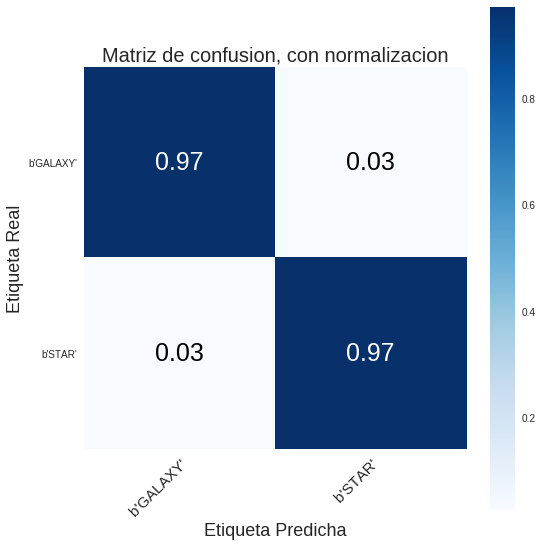

In [33]:
plot_confusion_matrix(test_y, pred_test, classes=clases, normalize = True,
                      title='Matriz de confusion, con normalizacion')

#REGRESIÓN LOGÍSTICA

In [34]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='auto')
lr_clf.fit(train_X,train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
pred_test = knn_clf.predict(test_X)
pred_test

array([1, 0, 0, ..., 0, 0, 0])

In [36]:
test_y

array([1, 0, 0, ..., 0, 0, 0])

Matriz de confusion normalizada
[[0.97271349 0.02728651]
 [0.02938296 0.97061704]]


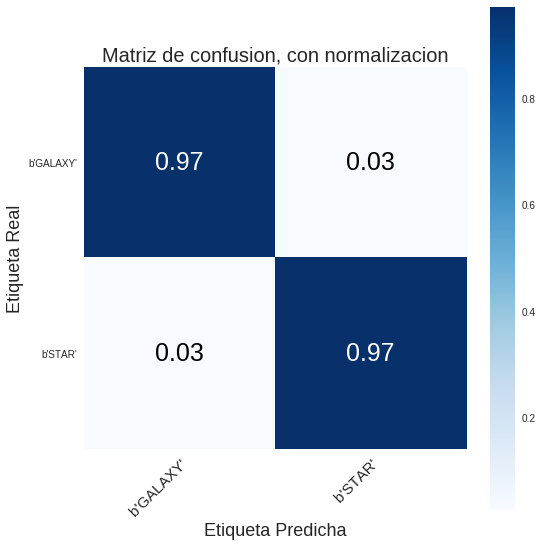

In [37]:
plot_confusion_matrix(test_y, pred_test, classes=clases, normalize = True,
                      title='Matriz de confusion, con normalizacion')